# Description of Dataset
**Data is Beautiful, is a place for visual representations of data: Graphs, charts, maps, etc. DataIsBeautiful is for visualizations that effectively convey information. Aesthetics are an important part of information visualization, but pretty pictures are not the aim of this subreddit.This dataset contains a couple of fields with the information based on Reddit post submission, such as : id,title,score,author,authorfalirtext,removed_by,totalawardsreceived,awarders,created_utc,full_link,num_commnets,over_18**
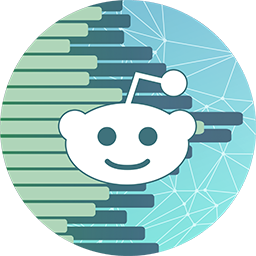

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing The Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from keras.models import Sequential
from keras.layers import Dense

# Loading the Dataset

In [ ]:
df = pd.read_csv("../input/dataisbeautiful/r_dataisbeautiful_posts.csv")

# Data Visualization and Preprocessing 

In [ ]:
df.head()

In [ ]:
df.isna().sum() # Checking for 'Nan' values if any

**Deleting columns that are of no use**

In [ ]:
del df['author_flair_text']
del df['removed_by']
del df['total_awards_received']
del df['awarders']
del df['id']
del df['created_utc']
del df['full_link']

In [ ]:
df.head()

In [ ]:
df.title.fillna(" ",inplace = True)

In [ ]:
df.title.value_counts()

In [ ]:
df['text'] = df['title'] + ' ' + df['author']
del df['title']
del df['author']

In [ ]:
df.head()

In [ ]:
df.over_18.replace(True,1,inplace = True)
df.over_18.replace(False,0,inplace = True)

In [ ]:
df.over_18.value_counts()

**Splitting the data into 2 parts - training and testing data**

In [ ]:
x = df[:100000]
train_false = x[x.over_18 == 0.0].text
train_true = x[x.over_18 == 1.0].text
train_text = df.text.values[:100000]
test_text = df.text.values[100000:]
train_category = df.over_18[:100000]
test_category = df.over_18[100000:]

**WORDCLOUD FOR OVER 18 TEXT (LABEL 1) **

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(train_true)))
plt.imshow(wc,interpolation = 'bilinear')

**We will now hypothesise importance of some words (most frequently used 3000 words) using WordCloud and based on that we will test and check if our hypothesis is correct**

In [ ]:
text_true = wc.process_text(str(" ".join(train_true))) # Getting the most frequently used words from wordcloud 
list(text_true.keys())[:10]

In [ ]:
len(text_true.keys())

**Sorting dictionary based on key values**

In [ ]:
 text_true = sorted(text_true.items(),key = 
             lambda kv:(kv[1], kv[0]))

In [ ]:
ans_true = []
for i in text_true:
    ans_true.append(i[0])
ans_true [:5] 

**Now for each word in every test data point , we will just check that if any word of that test data point is present in our dictionary ans_true which contains the most frequent 3000 words of label 1. If the word is present , then we will simply predict 1, otherwise 0.**

In [ ]:
predictions = []
for i in test_text:
    x = i.split()
    for j in x:
        if j in ans_true:
            predictions.append(1)
            break
        else:
            predictions.append(0)
            break
len(predictions)

In [ ]:
len(test_category)

In [ ]:
count = 0
for i in range(len(predictions)):
    test_category = list(test_category)
    if(predictions[i] == int(test_category[i])):
        count += 1
print(count)

In [ ]:
accuracy = (count/len(predictions))*100
accuracy

In [ ]:
print("Accuracy using WordCloud is : ", accuracy , "%")

**Wow! Using just WordCloud, we have got an 89 accuracy! Now we will compare this result by testing this dataset on different classifiers.**

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

**WHAT IS LEMMATIZATION AND STEMMING?**

**For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.
The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance:**
* am, are, is $\Rightarrow$ be
* car, cars, car's, cars' $\Rightarrow$ car
* The result of this mapping of text will be something like:
* the boy's cars are different colors $\Rightarrow$
* the boy car be differ color

**However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma. Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source.**

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text        

In [ ]:
df.text = df.text.apply(lemmatize_words)

In [ ]:
def join_text(text):
    string = ''
    for i in text:
        string += i.strip() +' '
    return string    

In [ ]:
df.text = df.text.apply(join_text)

**Splitting the data into 2 parts - training and testing data**

In [ ]:
train_message = df.text[:150000]
test_message = df.text[150000:]
train_category = df.over_18[:150000]
test_category = df.over_18[150000:]

**WHAT DOES COUNT VECTORIZER AND TFIDF VECTORIZER DO?**

**CountVectorizer just counts the word frequencies. Simple as that.**

**With the TFIDFVectorizer the value increases proportionally to count, but is offset by the frequency of the word in the corpus. - This is the IDF (inverse document frequency part).**

**This helps to adjust for the fact that some words appear more frequently.
How often do you really use crepuscular, and petrichor?
Sure, they are important words, and should be used when appropriate, but how often do we really use them?
Without the inverse document frequency part common, less meaning giving words such as “the” (assuming you don’t filter stopwords) would bear a higher weight than these less frequent words.
Inverse document frequency is defined as:**

**idf(t,D)=logN|d∈D:t∈d|**

**Where N is the total number of documents in the corpus, and |d∈D:t∈d| is the number of documents where t appears.**

In [ ]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,2))
#transformed train reviews
cv_train_reviews=cv.fit_transform(train_message)
#transformed test reviews
cv_test_reviews=cv.transform(test_message)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

In [ ]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_message)
#transformed test reviews
tv_test_reviews=tv.transform(test_message)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

# TRAINING WITH DIFFERENT CLASSIFIERS AND ANALYSIS AFTER TESTING

In [ ]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_category)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_category)
print(lr_tfidf)

In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)

In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_category,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_category,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

In [ ]:
#Classification report for bag of words
lr_bow_report=classification_report(test_category,lr_bow_predict,target_names=['0','1'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_category,lr_tfidf_predict,target_names=['0','1'])
print(lr_tfidf_report)

In [ ]:
plot_confusion_matrix(lr_bow, cv_test_reviews, test_category,display_labels=['0','1'],cmap="Blues",values_format = '')
plot_confusion_matrix(lr_tfidf, tv_test_reviews, test_category,display_labels=['0','1'],cmap="Blues",values_format = '')

In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_category)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_category)
print(mnb_tfidf)

In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)

In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_category,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_category,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

In [ ]:
mnb_bow_report = classification_report(test_category,mnb_bow_predict,target_names = ['0','1'])
print(mnb_bow_report)
mnb_tfidf_report = classification_report(test_category,mnb_tfidf_predict,target_names = ['0','1'])
print(mnb_tfidf_report)

In [ ]:
plot_confusion_matrix(mnb_bow, cv_test_reviews, test_category,display_labels=['0','1'],cmap="Blues",values_format = '')
plot_confusion_matrix(mnb_tfidf, tv_test_reviews, test_category,display_labels=['0','1'],cmap="Blues",values_format = '')

In [ ]:
model = Sequential()
model.add(Dense(units = 128 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(cv_train_reviews,train_category , epochs = 3 , batch_size = 128 , validation_data = (cv_test_reviews,test_category))

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(cv_test_reviews)
predictions[:5]

In [ ]:
print(classification_report(test_category, predictions, target_names = ['0','1']))

In [ ]:
cm = confusion_matrix(test_category,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')